# Code for gaussian benchmark baselines

## 1. Imports

In [1]:
from eot_benchmark.gaussian_mixture_benchmark import (
    get_guassian_mixture_benchmark_sampler,
    get_guassian_mixture_benchmark_ground_truth_sampler, 
)

from eot_benchmark.metrics import (
    compute_BW_UVP_by_gt_samples, calculate_gm_mmd
)

In [2]:
import math
import gc
import wandb
import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

In [3]:
gc.collect(); torch.cuda.empty_cache()

## 2. Config

In [4]:
DIM = 2
EPS = 10
assert DIM > 1

L1 = 1e-10
GPU_DEVICE = 1
EPSILON = EPS
BATCH_SIZE = 32

SEED = 42
MAX_STEPS = 501
METRICS_INTERVAL = 500
CONTINUE = -1

# identity, independet, linear
BASELINE_TYPE = "identity"

In [5]:
EXP_NAME = f'Gaussians_{BASELINE_TYPE}_baseline_EPSILON_{EPSILON}_DIM_{DIM}'

config = dict(
    DIM=DIM,
    EPSILON=EPSILON,
    SEED=SEED,
    MAX_STEPS=MAX_STEPS,
)

In [6]:
# assert torch.cuda.is_available()
# torch.cuda.set_device(GPU_DEVICE)

## 3. Initialize Benchmark

In [7]:
torch.manual_seed(SEED); np.random.seed(SEED);
X_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="input", dim=DIM, eps=EPS,
                                           batch_size=BATCH_SIZE, device="cpu", download=True)
Y_sampler = get_guassian_mixture_benchmark_sampler(input_or_target="target", dim=DIM, eps=EPS,
                                          batch_size=BATCH_SIZE, device="cpu", download=False)

ground_truth_plan_sampler = get_guassian_mixture_benchmark_ground_truth_sampler(dim=DIM, eps=EPS,
                                                                                batch_size=BATCH_SIZE, 
                                                                                device="cpu",
                                                                                download=False)

Downloading...
From: https://drive.google.com/uc?id=1HNXbrkozARbz4r8fdFbjvPw8R74n1oiY
To: /root/eot_benchmark_data/gaussian_mixture_benchmark_data.zip
100%|██████████| 146k/146k [00:00<00:00, 2.08MB/s]


In [8]:
pca = PCA(n_components=2)

samples = X_sampler.sample(10000)
samples = samples.cpu()

target_samples = Y_sampler.sample(10000)
target_samples = target_samples.cpu()

# pca.fit(torch.cat((samples, target_samples)))
pca.fit(target_samples)

PCA(n_components=2)

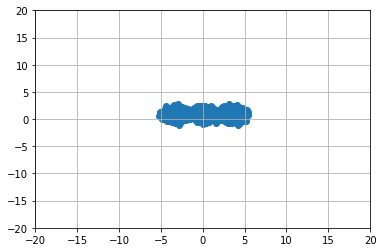

In [9]:
samples_pca = pca.transform(samples)

plt.scatter(samples_pca[:, 0], samples_pca[:, 1])
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.grid()

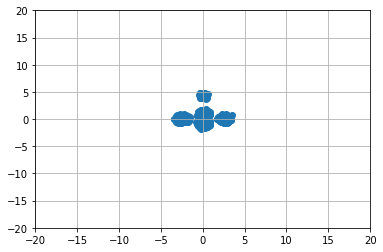

In [10]:
target_samples_pca = pca.transform(target_samples)
plt.scatter(target_samples_pca[:, 0], target_samples_pca[:, 1])
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.grid()

## 4. Model initialization

In [11]:
class IdentityBaseline(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x
    

class IndependentBaseline(nn.Module):
    def __init__(self, target_sampler):
        super().__init__()
        self.target_sampler = target_sampler

    def forward(self, x):
        return self.target_sampler.sample(x.shape[0]).to(x.device)
    

def symmetrize(X):
    return np.real((X + X.T) / 2)

def get_D_sigma(covariance_0, covariance_T, epsilon):
    shape = covariance_0.shape[0]
    
    covariance_0_sqrt = symmetrize(sqrtm(covariance_0))
    return symmetrize(sqrtm(4*covariance_0_sqrt@covariance_T@covariance_0_sqrt + (epsilon**2)*np.eye(shape)))

def get_C_sigma(covariance_0, D_sigma, epsilon):
    shape = covariance_0.shape[0]
    
    covariance_0_sqrt = symmetrize(sqrtm(covariance_0))
    covariance_0_sqrt_inv = inv(covariance_0_sqrt)
    
    return 0.5*(covariance_0_sqrt@D_sigma@covariance_0_sqrt_inv - epsilon*np.eye(shape))
    
    
class LinearBaseline(nn.Module):
    def __init__(self, original_sampler, target_sampler, epsilon, device="cpu"):
        super().__init__()
        original_samples = original_sampler.sample(100*1000).numpy()
        original_samples_covariance = np.cov(original_samples.T)
        original_samples_mu = original_samples.mean(axis=0)
        
        target_samples = target_sampler.sample(100*1000).numpy()
        target_samples_covariance = np.cov(target_samples.T)
        target_samples_mu = target_samples.mean(axis=0)
        
        D_sigma = get_D_sigma(original_samples_covariance, target_samples_covariance, epsilon)
        C_sigma = get_C_sigma(original_samples_covariance, D_sigma, epsilon)
        
        original_samples_covariance_inv = inv(original_samples_covariance)
        
        self.mu_0 = torch.tensor(original_samples_mu).to(device)
        self.mu_1 = torch.tensor(target_samples_mu).to(device)
        
        self.covariance_0 = torch.tensor(original_samples_covariance).to(device)
        self.covariance_0_inv = torch.tensor(original_samples_covariance_inv).to(device)
        self.covariance_1 = torch.tensor(target_samples_covariance).to(device)
        
        self.C_sigma = torch.tensor(C_sigma).to(device)
        
        self.weight =  self.C_sigma.T@self.covariance_0_inv
        self.bias = self.mu_1[:, None] - self.weight@self.mu_0[:, None]
        self.final_covariance = self.covariance_1 - self.C_sigma.T@self.covariance_0_inv@self.C_sigma
        
        
        
#         self.original_sigma = 
#         self.target_mu = 
#         self.target_sigma = 

    def forward(self, x):
        randn = torch.randn_like(x).to(device)
        
        return 

if BASELINE_TYPE == "identity":
    model = IdentityBaseline()
elif BASELINE_TYPE == "independet":
    model = IndependentBaseline(Y_sampler)

In [12]:
X, Y = ground_truth_plan_sampler.sample(10000)
X_indp = X_sampler.sample(10000)
Y_indp = Y_sampler.sample(10000)

In [13]:
# mmd = calculate_gm_mmd_dim_normalized(torch.cat((X_indp, Y_indp), dim=-1),
#                                       torch.cat((X, Y), dim=-1),
#                                       dim=DIM, eps=EPS)
# mmd

In [14]:
# mmd = calculate_gm_mmd_dim_normalized(torch.cat((X, Y), dim=-1),
#                                       torch.cat((X, Y), dim=-1),
#                                       dim=DIM, eps=EPS)
# mmd

In [15]:
# # mmd_plan_distance_kernel = calculate_gm_mmd_distance_kernel(torch.cat((X_input, predict), dim=-1),
#                                                               torch.cat((X, Y), dim=-1),
#                                                               dim=DIM, eps=EPS)
# mmd_plan_distance_kernel

## 5. Training

In [16]:
wandb.init(name=EXP_NAME, config=config, project='SchrodingerBridge')

wandb: Currently logged in as: schrodinger_bridge (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.14.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [17]:
torch.manual_seed(SEED); np.random.seed(SEED)

for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    model.train()
    
    if step % METRICS_INTERVAL == 0:
        model.eval()
        # metrics
        with torch.no_grad():
            # bw-uvp
            X = X_sampler.sample(100000)
            Y = Y_sampler.sample(100000)
            XN = model(X)
            
            X0_gt, XN_gt = ground_truth_plan_sampler.sample(100000)
            X0_XN_gt = torch.cat((X0_gt, XN_gt), dim=1)
            X0_XN = torch.cat((X, XN), dim=1)
            
            bw_uvp_target = compute_BW_UVP_by_gt_samples(XN.cpu().numpy(), Y.cpu().numpy())
            bw_uvp_plan = compute_BW_UVP_by_gt_samples(X0_XN.cpu().numpy(), X0_XN_gt.cpu().numpy())
            
            # mmd
            X = X_sampler.sample(10000)
            Y = Y_sampler.sample(10000)
            XN = model(X)
            
            X0_gt, XN_gt = ground_truth_plan_sampler.sample(10000)
            X0_XN_gt = torch.cat((X0_gt, XN_gt), dim=1)
            X0_XN = torch.cat((X, XN), dim=1)
            
#             mmd_plan = calculate_gm_mmd(X0_XN, X0_XN_gt, dim=DIM, eps=EPS)
#             mmd_plan_dim_normalized = calculate_gm_mmd_dim_normalized(X0_XN, X0_XN_gt, dim=DIM, eps=EPS)
#             mmd_plan_distance_kernel = calculate_gm_mmd_distance_kernel(X0_XN, X0_XN_gt, dim=DIM, eps=EPS)
            
#             mmd_target = calculate_gm_mmd(XN, Y, dim=DIM, eps=EPS)
#             mmd_target_dim_normalized = calculate_gm_mmd_dim_normalized(XN, Y, dim=DIM, eps=EPS)
#             mmd_target_distance_kernel = calculate_gm_mmd_distance_kernel(XN, Y, dim=DIM, eps=EPS)

            mmd_plan = calculate_gm_mmd(X0_XN, X0_XN_gt, dim=DIM, eps=EPS,
                                        normalization_type="indep_plan_rbf_kernel")
            mmd_plan_dim_normalized = calculate_gm_mmd(X0_XN, X0_XN_gt, dim=DIM, eps=EPS,
                                                       normalization_type="indep_plan_rbf_kernel_dim_norm")
            mmd_plan_distance_kernel = calculate_gm_mmd(X0_XN, X0_XN_gt, dim=DIM, eps=EPS,
                                                        normalization_type="indep_plan_rbf_distance_kernel")
            
            mmd_target = calculate_gm_mmd(XN, Y, dim=DIM, eps=EPS, normalization_type="identity_rbf_kernel")
            mmd_target_dim_normalized = calculate_gm_mmd(XN, Y, dim=DIM, eps=EPS,
                                                         normalization_type="indentity_rbf_kernel_norm")
            mmd_target_distance_kernel = calculate_gm_mmd(XN, Y, dim=DIM, eps=EPS, 
                                                          normalization_type="identity_distance_kernel")
            
            wandb.log({f'BW-UVP_target' : bw_uvp_target}, step=step)
            wandb.log({f'BW-UVP_plan' : bw_uvp_plan}, step=step)
            
            wandb.log({f'MMD_plan' : mmd_plan}, step=step)
            wandb.log({f'MMD_plan_dim_normalized' : mmd_plan_dim_normalized}, step=step)
            wandb.log({f'MMD_plan_distance_kernel' : mmd_plan_distance_kernel}, step=step)
            
            wandb.log({f'MMD_target' : mmd_target}, step=step)
            wandb.log({f'MMD_target_dim_normalized' : mmd_target_dim_normalized}, step=step)
            wandb.log({f'MMD_target_distance_kernel' : mmd_target_distance_kernel}, step=step)

    gc.collect(); torch.cuda.empty_cache()

100%|██████████| 501/501 [00:52<00:00,  9.51it/s]
